## 회고

#### Point 1) `Keras Tensor`와 `Tensorflow Tensor`의 차이
- CAM을 생성하려면 모델 중간에 있는 Conv 레이어의 output을 추출해내야 한다.
- 그런데 이 경우 그것을 진짜 output으로 하는 모델에서 갖고 나오는 게 아니라 중간에서 갖고 나오면 자료형이 Keras Tensor가 되어버리고 이 경우 일반적인 Tensorflow Tensor와 다르기 때문에 많은 문제가 생긴다.('convert keras tensor to tensorflow tensor'라고 구글링하면 금방 해결될 줄 알았던 문제가 3시간 동안 해결이 안되었다...........)
- 문제는 특히 저렇게 나온 keras tensor를 갖고 numpy array 스럽게 사용해야 할 경우 발생하는데(예: 이미지를 출력하거나, 뭔가 array 같이 수정하거나...), keras tensor는 내가 파악하기로는 **절대로** numpy array 같이 될 수 있는 방법이 없다...
- 참고로, keras tensor와 eager tensor 사이에 연산을 시키면 되긴 한다. 그러나 그 최종 값 자료형이 keras tensor여서 numpy array 같이 뭔가 볼 수가 없다.
- 이유는 대략적으로 찾아보니 keras tensor의 경우 실체가 있는 tensor(즉, 값이 있는)가 아니라 뭔가 방정식에 쓰여 있는 x 변수 같이 모양만 잡혀 있는 symbolic한 애들이라서 그렇다는 것 같다.
- 그래서 내가 고안해낸 방법은 저렇게 모델 중간에서 빼내오지 말고 그 빼내오려는 것 자체를 또 하나의 output으로 갖는 `tf.keras.Model()`을 만들어야 한다.(사실 이렇게 실습 코드에 있었지만, 이런 이유가 있을 줄이야...)
- 여튼, Keras Tensor 자료형을 만났는데 numpy array 같이 써야한다면, 괜히 conversion 방법 같은 거 구글링 하지 말고 원하는 값이 모델 output으로 나오게끔 하자.

#### Point 2) OpenCV에는 numpy array가 들어가야 한다.
- `cv2.addWeighted()`으로 두 이미지를 blending해서 합치고 싶을 때 tensorflow 자료형을 넣으면 오류가 난다.
- 그런데 문제는 이게 자료형 때문인지 Error에 잘 표시가 안 나는 것 같다. 처음에는 정수형이 아니어서 그런줄 알고 정수형으로 바꾸고, 값의 범위가 제대로 세팅 안되어 있는 것 같아서 다시 세팅해주고 했었는데, 알고보니 tensorflow 자료형을 argument로 넣으면 안되는 것이었다.
- 그래서 정리를 하자면, `cv2.addWeighted()`에는 1) numpy array 자료형이 들어가야 하고, 2) 0 ~ 255 사이의 정수값을 가져야 한다.
- `OpenCV`를 사용할 때는 numpy array 자료형으로 사용해야 하는 것을 기억하자...!

#### Point 3) Gradient Vanishing
- CAM은 마지막 단계에 있는 feature map을 뽑아서 사용하는데, 초반에 CAM 구현 함수를 작성하고 실행해봤더니 CAM의 모든 값이 0을 갖고 있었다.
- 뭐가 잘못됐나 싶어 한참을 함수를 들여다보고 했는데, 결론은 모델의 어느 지점부터 feature map output들이 0값에 수렴한다는 사실을 깨닫게 되었다.
- 나는 이게 gradient vanishing이 아닌가 싶다.
- 사실 모델을 처음 생성하고 바로 CAM을 만들었을 때는 그냥 어렴풋이 괜찮게 나오다가, 모델을 2 epoch 정도 훈련시키고 나서 CAM을 생성하니 그때부터 모든 값이 0이었던 것이다.(모델은 논문처럼 VGG16을 사용했고, 훈련을 몇 번 더 시켜도 training accuracy가 0.0068 수준으로 나오고 loss도 4.7888 정도에서 계속 머물렀다.)
- 종합해보면, 어쩌다가 초기화된 weight, 혹은 VGG16 모델의 단점 같은 특성 때문에 약 2 epoch만에 gradient가 모두 소실한 것으로 보였으며, 그래서 가장 마지막 단에 있는 Conv 레이어의 feature map은 0 값에 수렴해 있다라고 판단했다.
- 해결 방안으로는 그냥 모델을 바꿨고(ResNet-50으로), 해당 모델 훈련을 통해 loss가 정상적으로 내려가는지 확인한 후 CAM을 생성해보니 그 때는 괜찮은 CAM이 나왔다.

#### Point 4) BBox....
- 그냥 한 마디로 굉장히 어려웠다.
- array의 (W, H) 혹은 (H, W) 순서 및 8개 좌표가 필요한 것과 4개 좌표만 있으면 되는 것들... 그리고 8개 좌표에서 x, y는 어떤 것들인지..... 그림판으로도 굉장히 간단히 그릴 수 있는 사각형을 자동화하려니 이렇게 어려운 줄 몰랐다. 그리고 굉장히 머리 아파하며 헤맸다...
- 그러나 이것도 한 번 부딪히면 된다. 어려워도 차근차근 한 걸음씩 나아가면 되는 것이다.
- 덕분에 4개 좌표 값을 8개 좌표 값으로 바꾸는 함수는 노드의 도움 없이 나 혼자 만들 수 있었다...!


---

## 프로젝트: CAM을 만들고 평가해 보자

#### 배경
- CAM, Grad-CAM과 이를 통해 수행할 수 있는 object localization task에 대해 개념적으로 이해했다.
- 위의 이해를 바탕으로 CAM vs Grad-CAM에서 나온 시각화 정보를 비교할 수 있다.
- 이에 필요한 코드의 흐름을 예제로 경험해봤다.

### 1) 라이브러리 버전 확인
---


In [1]:
import tensorflow as tf
import numpy as np
import cv2
import PIL
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import copy

print(tf.__version__)
print(np.__version__)
print(cv2.__version__)
print(PIL.__version__)
print(tfds.__version__)

2.8.0
1.21.5
4.1.2
7.1.2
4.0.1


### 2) 예제 데이터셋 가져오기
---
- 이번 프로젝트에서는 추후 IoU를 계산해야 하기 때문에 Ground Truth의 bounding box 정보 라벨을 갖고 있는 데이터셋이 필요하다.
- 또한 CAM을 생성함에 있어서는 분류 문제를 다루는 모델을 생성해야 하므로(CAM의 한계), 분류 관련 라벨 정보도 갖고 있어야 한다.
- **위를 바탕으로 하면**,
  - 1) 데이터셋 전처리를 할 때는 데이터셋의 자료형이 (image, label) 조합의 구조를 가져야 한다.(bbox 가 포함된 데이터셋은 `model.fit()`으로 훈련 시 custom하게 타겟값을 뽑아내줘야할 듯하다.)
  - 2) 하지만 추후 CAM, Grad-CAM의 localisation 능력을 보기위해선 bbox 자료가 필요하다.
  - 3) 따라서 데이터셋이, 
     - 모델 내 분류 훈련을 할 때는 `(image, label(클래스)) 구조`여야 하고
     - Object localisation 시각화할 때는 `(image, label, bbox 등)의 구조`여야 bbox 정보를 통한 IoU 계산이 가능하다.

In [2]:
# stanford_dogs 데이터 가져오기
(ds_train, ds_test), ds_info = tfds.load('stanford_dogs', split=['train', 'test'], with_info=True)

In [3]:
print(ds_train.cardinality())
print(ds_test.cardinality())

tf.Tensor(12000, shape=(), dtype=int64)
tf.Tensor(8580, shape=(), dtype=int64)


In [4]:
ds_info

tfds.core.DatasetInfo(
    name='stanford_dogs',
    version=0.2.0,
    description='The Stanford Dogs dataset contains images of 120 breeds of dogs from around
the world. This dataset has been built using images and annotation from
ImageNet for the task of fine-grained image categorization. There are
20,580 images, out of which 12,000 are used for training and 8580 for
testing. Class labels and bounding box annotations are provided
for all the 12,000 images.',
    homepage='http://vision.stanford.edu/aditya86/ImageNetDogs/main.html',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
        'objects': Sequence({
            'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
        }),
    }),
    total_num_examples=20580,
    splits={
        'test': 8580,
        'train': 12000,
    },
    supervised_keys=('image'

In [5]:
# classification 카테고리 가짓수 할당해놓기
num_classes = ds_info.features['label'].num_classes
num_classes

120

In [6]:
# 총 데이터 개수 할당해놓기
num_ds_train = ds_train.cardinality().numpy()
num_ds_train

12000

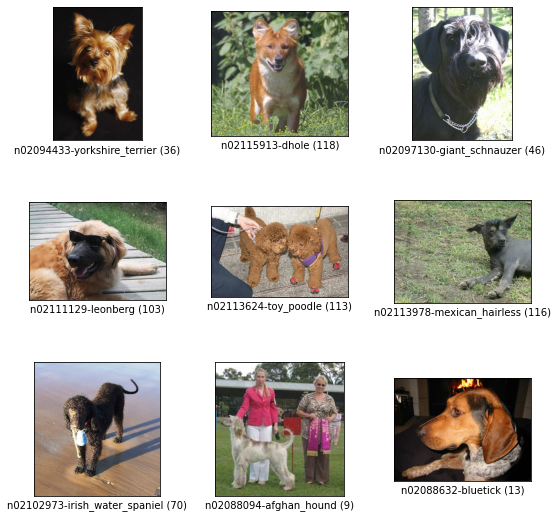

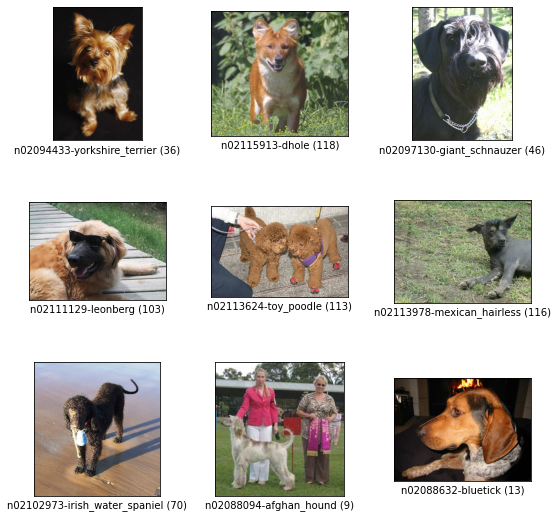

In [7]:
# 사진 예시 보기
tfds.show_examples(ds_train, ds_info)

#### 데이터셋 구조 파악

In [8]:
# 데이터셋 구조 파악 (1)
temp_taken_ds = list(ds_train.take(1).as_numpy_iterator())
temp_taken_ds

[{'image': array([[[14, 14, 14],
          [14, 14, 14],
          [14, 14, 14],
          ...,
          [19, 17, 20],
          [19, 17, 20],
          [19, 17, 20]],
  
         [[14, 14, 14],
          [14, 14, 14],
          [14, 14, 14],
          ...,
          [19, 17, 20],
          [19, 17, 20],
          [19, 17, 20]],
  
         [[14, 14, 14],
          [14, 14, 14],
          [14, 14, 14],
          ...,
          [19, 17, 20],
          [19, 17, 20],
          [19, 17, 20]],
  
         ...,
  
         [[19, 19, 19],
          [18, 18, 18],
          [18, 18, 18],
          ...,
          [23, 21, 22],
          [24, 22, 23],
          [24, 22, 23]],
  
         [[19, 19, 19],
          [18, 18, 18],
          [18, 18, 18],
          ...,
          [22, 20, 21],
          [22, 20, 21],
          [23, 21, 22]],
  
         [[19, 19, 19],
          [18, 18, 18],
          [18, 18, 18],
          ...,
          [21, 19, 20],
          [21, 19, 20],
          [22, 20, 21]]]

In [9]:
# 데이터셋 구조 파악 (2)
temp_taken_ds[0]['image'].shape # 배치 전

(500, 333, 3)

In [10]:
# 데이터셋 구조 파악 (3)
temp_taken_ds[0]['label']

36

In [11]:
# 데이터셋 구조 파악 (4)
temp_taken_ds[0]['objects']['bbox']

array([[0.044    , 0.2102102, 0.972    , 0.960961 ]], dtype=float32)

#### Resize 및 Normalise 함수
- 이미지 input 사이즈 통일과 원활한 모델 훈련을 위해 normalise가 필요하다.

In [12]:
# 이미지 사이즈 지정
img_size = [224, 224]

# 배치 사이즈 지정
BATCH_SIZE = 64

In [13]:
# 함수 생성
def resize_and_normalise(ds):
    img = ds['image']
    filename = ds['image/filename']
    label = ds['label']
    bbox = ds['objects']['bbox']

    img = tf.image.resize(img, img_size)
    img = tf.cast(img, tf.float32) / 255.

    # tf.data.Dataset.from_tensor_slices({'image':[img], 'image/filename':[filename], 'label':[label], 'bbox':[bbox]})
    # 위의 코드는 혹시나 데이터셋 원본 구조 그대로 유지할 경우의 return 값
    
    return img, label # 여기서 분류 모델에 필요하지 않은 정보들은 데이터셋에서 제외한다.

def preprocess_ds_for_classification(ds, is_test=False):
    ds = ds.map(resize_and_normalise)
    if not is_test:
        ds = ds.shuffle(num_ds_train)
        ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [14]:
# 전처리 실행
mds_train = preprocess_ds_for_classification(ds_train)
mds_test = preprocess_ds_for_classification(ds_test, is_test=True)

> **note**:
> - 현재 전처리 후 메모리에 있는 데이터셋들의 데이터 구조를 짚고 넘어가자면, `ds_train`은 bbox 등의 원본 데이터 정보를 유지하고 있고, 전처리를 거친 `mds_train`은 image + label 정보만 갖고 있다.

In [15]:
# 잘됐는지 배치 사이즈를 통해 확인
for img_batch, label_batch in mds_train.take(1):
    break

img_batch.shape

TensorShape([64, 224, 224, 3])

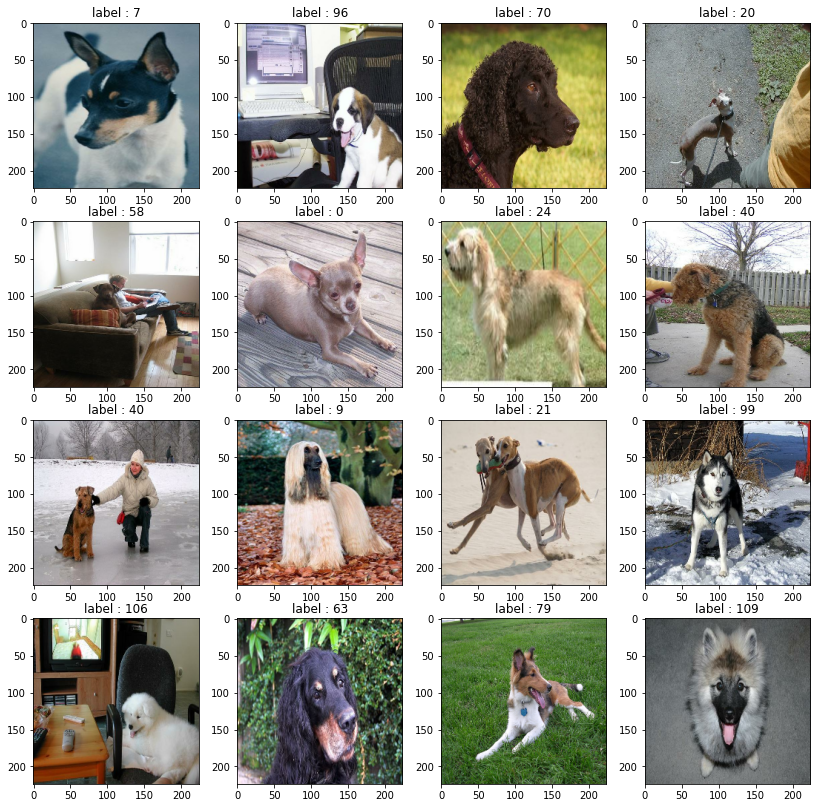

In [16]:
plt.figure(figsize=(14, 14))

for idx, (img, label) in enumerate(zip(img_batch, label_batch)):
    plt.subplot(4, 4, idx+1)
    plt.imshow(img)
    plt.title(f"label : {label}")
    if idx == 15:
        break

plt.show()

### 3) CAM 구현
---
- CAM을 구현하기 위해선 Global Avaerage Pooling과 Dense 레이어를 그 뒤에 붙인 모델을 생성해야 한다.
- backbone 모델로는 논문에 나와있는 VGG16을 사용해봤으나, gradient vanishing 문제가 생겨서  ResNet-50으로 바꿔서 사용할 예정이다.

#### CAM 모델 생성

> **note**:
> - 노트북을 몇 차례 수정하면서 모델을 생성, 훈련, 저장, 복원 등을 반복했었고, 최종적으로는 16 epoch 훈련된 ResNet-50 기반의 `cam_model`을 가져올 예정이다.
> - 몇 번 시도해본 결과 모델의 fit 상태에 따라 CAM의 주목 부분들이 달라지는 것 같다.
> - 이전에 훈련했거나, 모델을 생성하거나 한 부분이 아래에 주석 처리되어 있을 수 있다.

In [17]:
# # 베이스 ResNet 모델
# base_model = tf.keras.applications.resnet50.ResNet50(include_top=False, # 뒷 부분 제거
#                                                weights='imagenet',
#                                                input_shape=(224, 224, 3), 
#                                                pooling='avg') # 마지막 output을 Global Average Pooling 거쳐 나오게 하기

# # FCN + softmax 레이어
# # 해당 레이어를 윗 모델 끝에 붙이기
# fcn_softmax_layer = tf.keras.layers.Dense(num_classes, activation='softmax')                                        

# # 연결하기 (1)
# x = base_model.output
# y_pred = fcn_softmax_layer(x)

# # 연결하기 (2)
# cam_model = tf.keras.Model(inputs=base_model.input, outputs=y_pred)

# cam_model.summary()

In [18]:
# # 모델 컴파일
# cam_model.compile(loss='sparse_categorical_crossentropy',
#                   optimizer='adam',
#                   metrics=['accuracy'])

In [19]:
# # 모델 훈련(해당 데이터에 파라미터들 맞추기)
# cam_model.fit(mds_train,
#               epochs=2,
#               steps_per_epoch=num_ds_train//BATCH_SIZE)

In [20]:
from google.colab import drive
drive.mount("/content/drive")

cam_model_path = '/content/drive/My Drive/Aiffel/GD_06/model/cam_model1.h5'
# cam_model.save(cam_model_path)
cam_model = tf.keras.models.load_model(cam_model_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
cam_model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [22]:
# 모델 컴파일
cam_model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

#### Batch 단위가 아닌 1개의 샘플 데이터(이미지, 라벨, bbox가 있는) 가져오는 함수
- CAM 생성은 1개 샘플 단위로 생성되기 때문에 해당 함수가 필요하다.
- 이 때 하나의 샘플을 가져와서 이미지 및 라벨 값도 가져오는데, 라벨 값은 추후 CAM을 생성할 때 이미지에 따른 클래스별 weight을 구할 때도 필요하고, 여기서 샘플의 bbox는 생성된 시각화 정보의 localisation 비교에도 필요하다.

In [23]:
# 하나의 샘플 데이터만 가져온다.
def take_one_sample(ds):
    ds = ds.shuffle(100)
    ds = ds.take(1)
    ds = list(ds.as_numpy_iterator())
    return ds[0] # 리스트에서 벗기기

In [24]:
# 확인
sample = take_one_sample(ds_train)

print(f"image shape : {sample['image'].shape}")
print(f"image min_value : {sample['image'].min()}")
print(f"image max_value : {sample['image'].max()}")
print(f"image label : {sample['label']}")
print(f"image bbox : {sample['objects']['bbox']}")

image shape : (375, 500, 3)
image min_value : 0
image max_value : 255
image label : 21
image bbox : [[0.20533334 0.072      0.88266665 0.688     ]]


> **note**:
> - 이렇게 `take_one_sample()` 함수를 통해 가져온 샘플은 `resize_and_normalise`를 거치지 않은 상태이다.

#### CAM 생성하는 함수

- 아래는 CAM 구현을 위해 정리해본 구현 순서이다.
  1. 모델의 마지막 conv에서 output 가져오기
  2. GAP <-> FCN 사이의 weights 가져오기
    - 이 때 class(라벨)에 따른 weight 가져오기
  3. 1번의 output 채널들에 weight들 순서대로 각각 곱해서 더해주기(wieghted sum)
  4. 그것들 합쳐주기
  5. 원본 image 사이즈로 resize 해주기(Upsampling?)

In [25]:
# 마지막 conv 레이어 output 구해보기
cam_model.layers[-3].output

<KerasTensor: shape=(None, 7, 7, 2048) dtype=float32 (created by layer 'conv5_block3_out')>

In [26]:
# GAP <-> FCN 사이의 weights 가져오는 법 확인 (1)
cam_model.layers[-1].weights

[<tf.Variable 'dense/kernel:0' shape=(2048, 120) dtype=float32, numpy=
 array([[-0.01002095,  0.08179341, -0.02455395, ..., -0.1149409 ,
         -0.02672039, -0.05858839],
        [ 0.07484   , -0.01657713,  0.04289659, ...,  0.09619079,
         -0.01285798,  0.1281753 ],
        [-0.22107475, -0.15459068, -0.10140377, ...,  0.04980602,
         -0.04170594, -0.13063787],
        ...,
        [-0.05924918, -0.05105158,  0.03870807, ...,  0.04352427,
         -0.0681195 , -0.05871999],
        [-0.1571148 , -0.09710331, -0.05471346, ...,  0.01005854,
         -0.23945189, -0.03529937],
        [-0.02673243, -0.09355561,  0.02509847, ..., -0.02663215,
          0.09170119,  0.11775918]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(120,) dtype=float32, numpy=
 array([-0.00894121, -0.01437912,  0.00976228,  0.0146125 , -0.01636376,
        -0.0093577 , -0.01018995,  0.00297697,  0.00897572, -0.01208991,
         0.01557428, -0.00323346,  0.00068644, -0.00234027,  0.00642187,
   

> **note**:
> - CAM을 생성할 때 bias는 포함되지 않는다.

In [27]:
# GAP <-> FCN 사이의 weights 가져오는 법 확인 (2)
cam_model.layers[-1].weights[0][:, 0] # class 0일 경우의 weights

<tf.Tensor: shape=(2048,), dtype=float32, numpy=
array([-0.01002095,  0.07484   , -0.22107475, ..., -0.05924918,
       -0.1571148 , -0.02673243], dtype=float32)>

In [28]:
# broadcasting 확인
# (H, W, C)에서 H, W에 같은 값이 다 곱해져야 함

temp_map = tf.ones((14, 14, 3))

# H, W에 다 같은 값이고 C 축만 다른지 확인하기 위해 ones_like 사용
temp_map = tf.ones_like(temp_map)

# 가상 weight
temp_weight = tf.random.normal([temp_map.shape[-1]])

# feature map들에 가중치 각각 순서대로 곱하기
temp_ws = temp_map * temp_weight

print(f"0번째 채널 : {np.unique(temp_ws[:, :, 0], return_counts=True)}")
print(f"1번째 채널 : {np.unique(temp_ws[:, :, 1], return_counts=True)}")
print(f"2번째 채널 : {np.unique(temp_ws[:, :, 2], return_counts=True)}")

0번째 채널 : (array([-0.76435447], dtype=float32), array([196]))
1번째 채널 : (array([-0.81677383], dtype=float32), array([196]))
2번째 채널 : (array([0.60612184], dtype=float32), array([196]))


> **note**:
> - 윗 코드의 13번행처럼 단순히 `temp_map * temp_weight`으로 구현해도 각 채널마다 그에 대응되는 weight이 곱해진 것을 확인할 수 있다.(채널별로 값이 하나씩 다르게 있는 것을 통해 확인)
> - 이러면 굳이 실습 코드에서 하듯이 for loop을 하지 않고 한 번에 병렬적으로 처리가 가능할 것 같다.

original map shape : (14, 14, 3)
weight shape : (3,)
merged CAM shape : (14, 14)


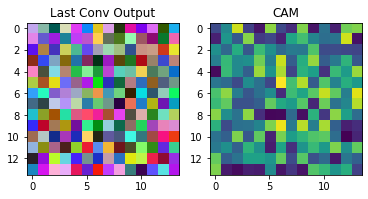

In [29]:
# ones_like말고 정규분포를 통해 가상 feature map 형성
temp_map = tf.random.uniform(temp_map.shape, minval=0, maxval=1)

# 가상 weight
temp_weight = tf.random.normal([temp_map.shape[-1]])

# feature map들에 가중치 각각 순서대로 곱하기
temp_ws = temp_map * temp_weight

# 가상 class activation map들 합쳐주기
temp_ws = tf.reduce_sum(temp_ws, axis=(2))

print(f"original map shape : {temp_map.shape}")
print(f"weight shape : {temp_weight.shape}")
print(f"merged CAM shape : {temp_ws.shape}")

plt.subplot(1, 2, 1)
plt.imshow(temp_map)
plt.title("Last Conv Output")

plt.subplot(1, 2, 2)
plt.imshow(temp_ws)
plt.title("CAM")

plt.show()

In [30]:
# 확인했으니 함수로 구현
def generate_cam(sample):
    sample = copy.deepcopy(sample)
    
    # 기본 정보 할당
    h = sample['image'].shape[0]
    w = sample['image'].shape[1]

    # input shape에 맞추기
    image, label = resize_and_normalise(sample)
    image = tf.expand_dims(image, axis=0)

    # 모델 생성
    model = tf.keras.Model(inputs=[cam_model.input], outputs=[cam_model.layers[-3].output, cam_model.output])

    # feature map 뽑아내기 => (1, 7, 7, 2048)
    maps, _ = model(image)

    # label에 따른 weights 뽑아내기 => (2048,)
    class_weights = cam_model.layers[-1].weights[0][:, label]

    # 각각 맞는 순서대로 곱하기 => (7, 7, 2048) * (2048,) element-wise
    cam = tf.squeeze(maps) * class_weights

    # 원래 사이즈에 맞게 resize하기 => (h, w, 2048)
    cam = tf.image.resize(cam, (h, w))

    # 채널값들 다 합치기 => (h, w)
    cam = tf.reduce_sum(cam, axis=2)

    # normalise하기(현재는 2048개의 채널값이 다 더해놔서 1을 초과한 float 형태임)
    cam = tf.math.divide(cam, tf.reduce_max(cam))
    return cam.numpy() # opencv에 쓰일 수 있도록 numpy array로 변환

In [31]:
# 샘플 확인해보기
sample_1 = take_one_sample(ds_train)

(622, 882)


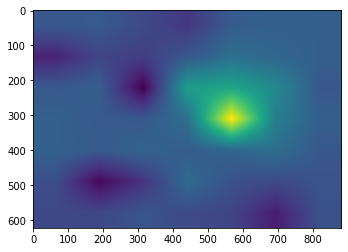

In [32]:
# 샘플 CAM 뽑기
cam_1 = generate_cam(sample_1)
print(cam_1.shape)
plt.imshow(cam_1)
plt.show()

(622, 882, 3)


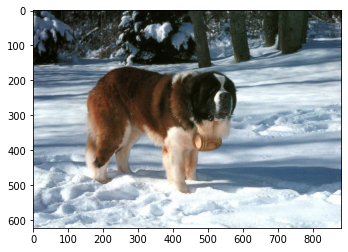

In [33]:
# 원본 이미지 보기
print(sample_1['image'].shape)
plt.imshow(sample_1['image'])
plt.show()

In [34]:
# 시각화 함수
def visualise_cam_on_image(image, cam):
    # CAM 이미지에 대해서
    if cam.max() <= 1 and len(cam.shape) == 2:
        cam = tf.cast(tf.stack([cam*255.0]*3, axis=2), tf.uint8) # 0 ~ 255의 정수값 및 3채널 어레이로 변환
    elif cam.max() > 1 and len(cam.shape) == 2: # 이미 0 ~ 255의 정수값으로 있을 경우
        cam = tf.stack([tf.cast(cam, tf.uint8)]*3, axis=2)
    elif cam.max() <= 1 and len(cam.shape) == 3: # 이미 3채널이지만 정수형으로 바꿔줘야 할 경우
        cam = tf.cast(cam * 255, tf.uint8)

    # 이미지에 대해서    
    if image.max() <= 1: # 이미지는 이미 3채널이다.
        image = tf.cast(image*255.0, tf.uint8)
    else:
        image = tf.cast(image, tf.uint8)
    merged = cv2.addWeighted(image.numpy(), 0.5, cam.numpy(), 0.5, 0.)
    return merged

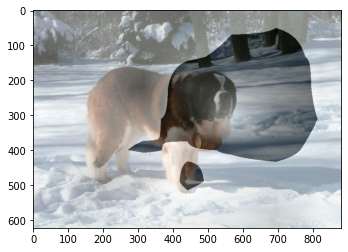

In [35]:
# 테스트로 합쳐보기
t_1 = visualise_cam_on_image(sample_1['image'], cam_1)

plt.imshow(t_1)

#### CAM : AIFFEL 노드 버전과 비교

- 내가 구현한 함수가 다른 부분이 있을 수도 있어서 실습시 사용했던 코드로 CAM을 뽑아보자.

In [36]:
# AIFFEL 버전
def generate_cam_aiffel(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = resize_and_normalise(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] #마지막 모델의 weight activation을 가져옵니다.
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

(622, 882)


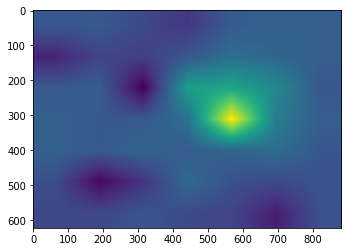

In [37]:
# 샘플 CAM_aiffel 뽑기
cam_1_aiffel = generate_cam_aiffel(cam_model, sample_1)
print(cam_1_aiffel.shape)
plt.imshow(cam_1_aiffel)
plt.show()

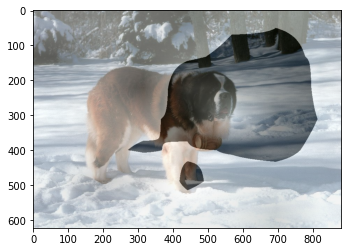

In [38]:
# 테스트로 합쳐보기
t_2 = visualise_cam_on_image(sample_1['image'], cam_1_aiffel)

plt.imshow(t_2)

> **note**:
> - 일단 `generate_cam` 함수의 로직은 완성된 것 같다.
> - 그러나 부자연스럽게 생기는 하얀색 하얀색 부분은 어떠한 이유로 생기는 것이고, 어떻게 보완하면 될지 모르겠다.

In [39]:
# # 모델 훈련(해당 데이터에 파라미터들 맞추기)
# # 현재까지 4 epoch 실시됐었음.
# # 지금의 추가 4 epoch를 통해 총 8 epoch 실시
# cam_model.fit(mds_train,
#               epochs=4,
#               steps_per_epoch=num_ds_train//BATCH_SIZE)

In [40]:
# # 모델 훈련(해당 데이터에 파라미터들 맞추기)
# # 현재까지 8 epoch 실시됐었음.
# # 지금의 추가 8 epoch를 통해 총 16 epoch 실시
# cam_model.fit(mds_train,
#               epochs=8,
#               steps_per_epoch=num_ds_train//BATCH_SIZE,
#               validation_data=mds_test,
#               validation_steps=ds_test.cardinality().numpy()//BATCH_SIZE)

In [41]:
# # 모델 저장
# cam_model.save(cam_model_path)

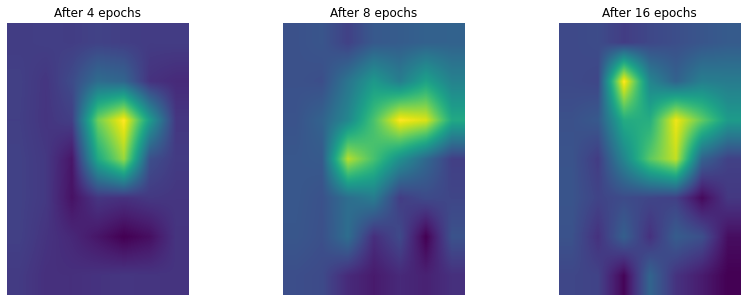

In [ ]:
# # 훈련량에 따른 CAM 모아보기

# plt.figure(figsize=(14, 5))
# plt.subplot(1, 3, 1)
# plt.imshow(cam_1)
# plt.axis('off')
# plt.title("After 4 epochs")

# plt.subplot(1, 3, 2)
# plt.imshow(cam_1_b)
# plt.axis('off')
# plt.title("After 8 epochs")

# plt.subplot(1, 3, 3)
# plt.imshow(cam_1_c)
# plt.axis('off')
# plt.title("After 16 epochs")

# plt.show()

> **note**:
> - 위의 사진들은 모델의 fit 상태에 따라 CAM이 어떻게 달라지는지 확인해본 결과로서 남겨놓는다. 
> - 처음에는 얼굴 쪽에만 머물러 있다가 훈련이 되고 모델이 해당 데이터에 fit하게 되면서 당시 샘플 이미지의 라벨값이었던 요크셔테리어(?)의 귀쪽에 중요도가 옮겨지는 것을 볼 수 있다.


### 4) Grad-CAM 구현
---
- Grad-CAM의 경우 중간의 가중치만 있으면 되어서 모델의 종류에 국한되지 않는다. 그래서 현재 생성된 ResNet-50 기반의 `cam_model`을 토대로 구현하도록 한다.
- 또한, Conv Network의 어느 레이어에 대해서도 가중치를 뽑아내서 Grad-CAM을 만들 수 있지만, 마지막 레이어의 feature map이 제일 함축된 특성들을 파악하고 있을 것으로 판단하기 때문에 논문처럼 마지막 레이어에 대해서만 Grad-CAM을 뽑아내도록 할 예정이다.

#### `tf.GradientTape()` 사용법 확인

In [42]:
# tf.GradientTape 사용 방법 확인

t_model = tf.keras.Model(inputs=cam_model.input, outputs=[cam_model.layers[-3].output, cam_model.output])
img_3dim, t_label = resize_and_normalise(sample_1)
img_4dim = tf.expand_dims(img_3dim, axis=0)
t_label = tf.cast(t_label, tf.int64)

with tf.GradientTape() as tape:
    maps, y_preds = t_model(img_4dim)
    # maps = maps[0]
    # class_score = y_preds[:, t_label]
    dy_dA = tape.gradient(y_preds[:, t_label], maps)[0] # gradient를 구할 때는 Tensor

In [43]:
print(f"type : {type(dy_dA)}")
print(f"shape : {dy_dA.shape}")

type : <class 'tensorflow.python.framework.ops.EagerTensor'>
shape : (7, 7, 2048)


In [44]:
# faeture map 확인
maps.shape

TensorShape([1, 7, 7, 2048])

In [45]:
# GAP한 형태 확인
tf.reduce_mean(maps[0], axis=[0, 1])

<tf.Tensor: shape=(2048,), dtype=float32, numpy=
array([0.1541489 , 0.05735178, 0.36159262, ..., 0.3186996 , 0.988615  ,
       0.26527384], dtype=float32)>

In [46]:
# 함수 구현(아래는 내가 생각한 순서 요약)
# 1) gradient 구하기(classification -> 마지막 conv 레이어 output에 대한)
# 2) 1번 GAP
# 3) 2번 x 각각의 feature map, 그리고 다 더해서 하나로 합치기
# 4) 3번 ReLU 통과시키기

def generate_grad_cam(sample):
    sample = copy.deepcopy(sample)

    # 모델에 들어갈 수 있게 준비
    h = sample['image'].shape[0]
    w = sample['image'].shape[1]
    image, label_idx = resize_and_normalise(sample)
    image = tf.expand_dims(image, axis=0)

    # 모델 설정
    model = tf.keras.Model(inputs=cam_model.input, outputs=[cam_model.layers[-3].output, cam_model.output])

    # ============================
    # # gradient 구하기
    # with tf.GradientTape() as tape:
    #     maps, y_preds = model(image)
    #     maps = tf.squeeze(maps)
    #     class_score = y_preds[:, label_idx]
    #     dy_dA = tape.gradient(class_score, maps)
    # print(dy_dA, 1)
    # ============================
    #     왜인지 모르겠지만 위의 경우로 실행할 경우 None 값이 반환된다.
    #     아래와 같이 tensor 자료형이 혹시나 바뀔 수 있는 것들은 with 구문 밖으로 빼줬다.

    # gradient 구하기
    with tf.GradientTape() as tape:
        maps, y_preds = model(image)
        dy_dA = tape.gradient(y_preds[:, label_idx], maps)[0]

    # gradient GAP해주기
    dy_dA = tf.reduce_mean(dy_dA, axis=[0, 1])

    # 곱해주기 & 하나로 합치기
    grad_cam = tf.reduce_sum(tf.squeeze(maps) * dy_dA, axis=-1)

    # ReLU 해주기
    grad_cam = tf.math.maximum(0, grad_cam)

    # normalise 해주기
    grad_cam = grad_cam / tf.reduce_max(grad_cam)

    # resize 해주기
    grad_cam = tf.expand_dims(grad_cam, axis=-1)
    grad_cam = tf.image.resize(grad_cam, [h, w]) # 이 부분을 위해서는 dim=3 이어야 함
    grad_cam = tf.squeeze(grad_cam, axis=-1)
    return grad_cam.numpy()

In [47]:
grad_cam_1 = generate_grad_cam(sample_1)

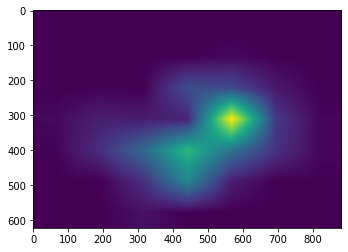

In [48]:
plt.imshow(grad_cam_1)
plt.show()

#### Grad-CAM : AIFFEL 노드 버전과 비교

In [49]:
def generate_grad_cam_aiffel(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = resize_and_normalise(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

In [50]:
grad_cam_1_aiffel = generate_grad_cam_aiffel(cam_model, 'conv5_block3_out', sample_1)

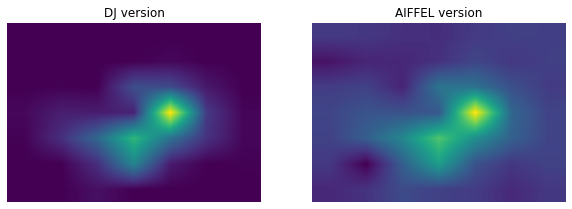

In [51]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(grad_cam_1)
plt.title("DJ version")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(grad_cam_1_aiffel)
plt.title('AIFFEL version')
plt.axis('off')

plt.show()

> **note**:
> - 아이펠 실습 버전에서는 ReLU가 포함되어 있지 않다.
> - 논문에는 ReLU가 들어가 있는데, 위와 같이 좀 더 특징 부분이 부곽되는 것 같다.

#### CAM과 Grad-CAM 원본에 합쳐서 비교해보기

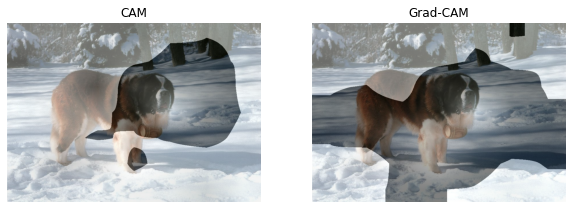

In [52]:
# 테스트로 합쳐보기
t_1_grad = visualise_cam_on_image(sample_1['image'], grad_cam_1_aiffel)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(t_1)
plt.title('CAM')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(t_1_grad)
plt.title('Grad-CAM')
plt.axis('off')

plt.show()

> **note**:
> - 흑백의 이미지를 합치니까 뭔가 이쁘지 않게 나오는 걸까..
> - 컬러로 CAM을 바꿔보자

In [53]:
# 컬러로 만드는 함수 설정
import matplotlib.cm as cm

jet = cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:, :3] # RGBA에서 RGB만 쓰기

# jet_colors[0 ~ 255사이의 정수형을 갖는 이미지 어레이]로 하면 컬러로 된다.

def coloured_cam(cam_img):
    assert cam_img.max() <= 1
    cam_img = np.uint8(cam_img * 255)
    coloured_img = jet_colors[cam_img]
    return coloured_img

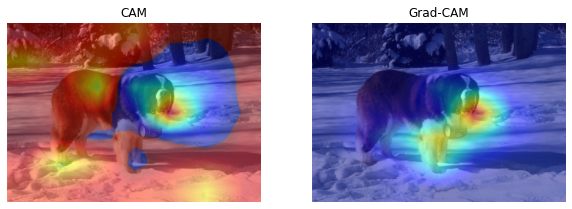

In [54]:
# 비교해보기
cam_1_coloured = visualise_cam_on_image(sample_1['image'], coloured_cam(cam_1))
grad_cam_1_coloured = visualise_cam_on_image(sample_1['image'], coloured_cam(grad_cam_1))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cam_1_coloured)
plt.title('CAM')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(grad_cam_1_coloured)
plt.title('Grad-CAM')
plt.axis('off')

plt.show()

### 5) CAM 이미지를 통한 바운딩 박스 추출
--- 
- 우선 만들어진 CAM 이미지를 넣어서 시각화 할 수 있는 bbox 좌표 값을 얻고, 이를 opencv 함수를 통해 시각화하도록 한다.

In [55]:
# bbox(8개 좌표)를 얻는 함수
def get_rect(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) # contour들을 다 찾는데, hierarchy는 안 쓴다.
    cnt = contours[0] # 첫번째 contour가 아니가 contour 모음들이 list에 요소로 있음
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect) # 박스 4 포인트 찾기
    rect = np.int0(rect) # 박스를 그리기 위해서는 int 자료형
    return rect

In [56]:
# bbox(8개 좌표)를 통해 이미지에 bbox를 그려보는 함수
def draw_bbox(sample, rect):
    image = copy.deepcopy(sample['image'])
    image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
    return image

In [57]:
# 위의 두 개를 합친 함수
def get_and_draw_bbox(sample, cam, pixel_thresh=0.5):
    low_indicies = cam <= pixel_thresh
    cam[low_indicies] = 0
    cam = (cam*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) # contour들을 다 찾는데, hierarchy는 안 쓴다.
    cnt = contours[0] # 첫번째 contour가 아니가 contour 모음들이 list에 요소로 있음
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect) # 박스 4 포인트 찾기
    rect = np.int0(rect) # 박스를 그리기 위해서는 int 자료형    
    # rect의 좌표 순서는
    # ([r, b],
    #  [l, b],
    #  [l, t],
    #  [r, t])

    image = copy.deepcopy(sample['image'])
    image_bbox = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
    return image_bbox, rect

In [58]:
# 여태까지 구한 cam, grad_cam에 대해 bbox 좌표 구해보기
bbox_on_original_by_cam_1, cam_1_rect = get_and_draw_bbox(sample_1, cam_1)
bbox_on_origianl_by_grad_cam_1, grad_cam_1_rect = get_and_draw_bbox(sample_1, grad_cam_1)

In [59]:
# CAM 위에 bbox 그려보기
cam_1_rect = get_rect(cam_1)
grad_cam_1_rect = get_rect(grad_cam_1)

cam_1_copy = copy.deepcopy(cam_1)
grad_cam_1_copy = copy.deepcopy(grad_cam_1)

bbox_on_cam_1 = cv2.drawContours(cam_1_copy, [cam_1_rect], 0, (0, 0, 255), 2)
bbox_on_grad_cam_1 = cv2.drawContours(grad_cam_1_copy, [grad_cam_1_rect], 0, (0, 0, 255), 2)

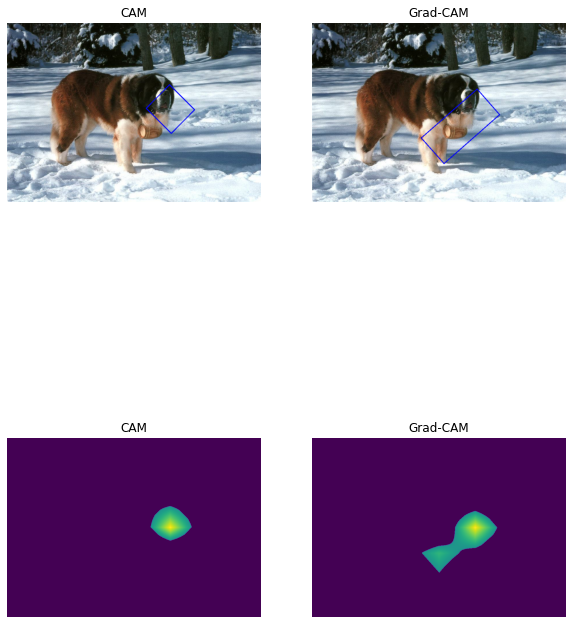

In [60]:
plt.figure(figsize=(10, 14))

plt.subplot(2, 2, 1)
plt.imshow(bbox_on_original_by_cam_1)
plt.title('CAM')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(bbox_on_origianl_by_grad_cam_1)
plt.title('Grad-CAM')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(bbox_on_cam_1)
plt.title('CAM')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(bbox_on_grad_cam_1)
plt.title('Grad-CAM')
plt.axis('off')

plt.show()

### 6) IoU 구하기
---
- bounding box와 관련하여 두 가지 데이터 구조가 필요하다.
- 1) 하나는 `[(x_min, y_min), (x_max, y_min), (x_max, y_max), (x_min, y_max)]` 형식의 8개 좌표 값이 들어있는 데이터이고, 이 데이터는 bbox를 시각화하는 `cv2.drawContours()` 함수에서 필요하다.
- 2) 또 하나는 `[y_min, x_min, y_max, x_max]` 형식의 4가지 값이 들어있는 데이터인데, 이는 tensorflow의 `BBoxFeature` 자료형과 같은 구조로서 predicted bbox와 데이터셋에 저장되어 있는 ground truth bbox 간의 IoU를 계산하기 위해서 필요하다.
- 현재 1번 형식의 데이터(8개 값)이 주어졌을 때 시각화를 함수는 구현되어 있다.
- 또한, 1번 형식 -> 2번 형식(4개 값)으로 바꿔주는 함수도 구현되어 있다.
- 그러나 2번 형식 -> 1번 형식으로 바꿔서 시각화가 가능하게 해주는 함수가 없어서 따로 구현할 예정이다.(이를 통해 ground truth가 어떻게 생겼는지 시각적으로도 확인해보자)

In [61]:
# 8개 좌표값 -> 4개 값으로 변환 함수
def rect_to_bbox(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return np.array(bbox, dtype=np.float32)

In [62]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0]) # 겹치면 둘 중 가장 높은 값이 겹치는 것의 가장 낮은 높이 값
    x_min= max(boxA[1], boxB[1]) # 겹치면 둘 중 가장 높은 값이 겹치는 것의 가장 낮은 넓이 값
    y_max = min(boxA[2], boxB[2]) # 겹치면 둘 중 가장 낮은 값이 겹치는 것의 가장 높은 높이 값
    x_max = min(boxA[3], boxB[3]) # 겹치면 둘 중 가장 낮은 값익 겹치는 것의 가장 높은 넓이 값
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min) # max(0, 값)으로 할 수 있는 이유는 안 겹칠 경우 한 축의 max - min이 음수로 나옴. max가 보니까 min보다 더 작아서
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    try:
        iou = interArea / float(boxAArea + boxBArea - interArea)
    except:
        epsilon = 1e-6
        iou = interArea / float(boxAArea + boxBArea - interArea + epsilon)
    return iou

In [63]:
# 4개 좌표값 -< 8개 좌표값으로 변환하는 함수
def bbox_to_rect(sample):
    sample = copy.deepcopy(sample)
    bbox = sample['objects']['bbox']
    assert len(bbox.shape) == 2 # 2차원 형태의 0 ~ 1 사이값

    # 이미지 사이즈에 맞게 좌표값을 키우기 위해 H, W 정보 할당
    image = sample['image']
    h = image.shape[0]
    w = image.shape[1]

    # 이미지 사이즈에 맞게 좌표값 복원
    bbox[0, :][0] = bbox[0, :][0] * h
    bbox[0, :][1] = bbox[0, :][1] * w
    bbox[0, :][2] = bbox[0, :][2] * h
    bbox[0, :][3] = bbox[0, :][3] * w    

    # 4개의 좌표를 8개로 만들기
    rect = np.array([
        [bbox[0, :][1], bbox[0, :][0]], # -> xmin, ymin
        [bbox[0, :][3], bbox[0, :][0]], # -> xmax, ymin
        [bbox[0, :][3], bbox[0, :][2]], # -> xmax, ymax
        [bbox[0, :][1], bbox[0, :][2]], # -> xmin, ymax
    ])

    # cv2.drawContours() 에 맞게 정수형으로 바꿔주기
    rect = rect.astype(np.int32)
    return rect

In [64]:
# 시각화해보기
sample_1_rect = bbox_to_rect(sample_1)

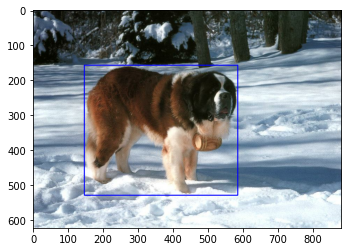

In [65]:
# 시각화해보기
plt.imshow(draw_bbox(sample_1, sample_1_rect))

#### IoU 구하기

In [66]:
# bbox들 정리해놓기
cam_1_bx = rect_to_bbox(cam_1_rect, cam_1)
grad_cam_1_bx = rect_to_bbox(grad_cam_1_rect, grad_cam_1)
gt_bx = sample_1['objects']['bbox']

In [67]:
# 확인
gt_bx

array([[0.25241157, 0.16553289, 0.84887457, 0.66213155]], dtype=float32)

In [68]:
# 확인
cam_1_bx

array([0.34405145, 0.54761904, 0.6157556 , 0.7380952 ], dtype=float32)

In [69]:
# 확인
grad_cam_1_bx

array([0.3681672, 0.4297052, 0.7845659, 0.7380952], dtype=float32)

In [70]:
# IoU 구하기
cam_1_iou = get_iou(cam_1_bx, gt_bx[0])
cam_1_iou

0.09819875482823863

In [71]:
# IoU 구하기
grad_cam_1_iou = get_iou(grad_cam_1_bx, gt_bx[0])
grad_cam_1_iou

0.29521668993880157

### 7) 다른 샘플에 대해서 적용해보기
---

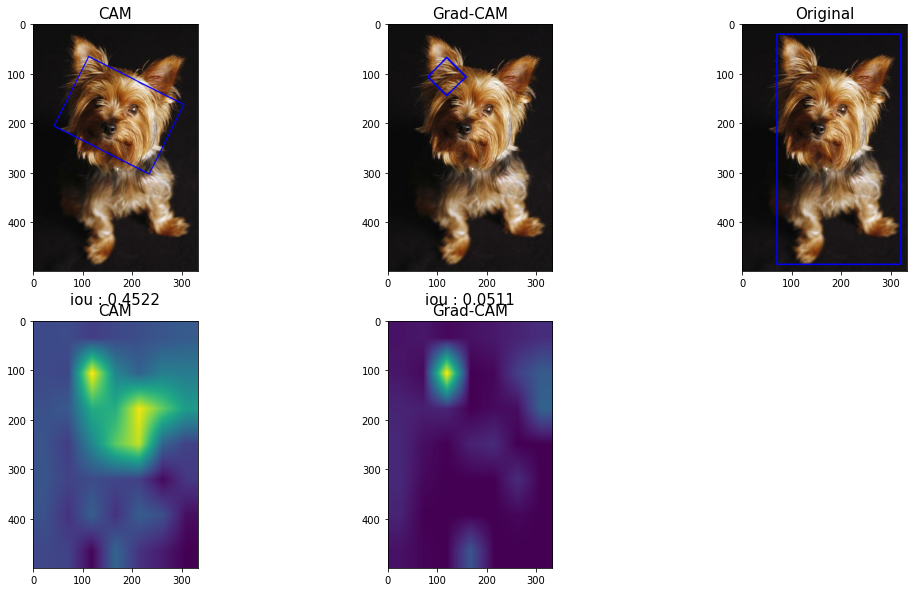

In [72]:
# 샘플 구하기
sample_2 = take_one_sample(ds_train)

# CAM, Grad-CAM
cam_2 = generate_cam(sample_2)
grad_cam_2 = generate_grad_cam(sample_2)

cam_2_copy = copy.deepcopy(cam_2)
grad_cam_2_copy = copy.deepcopy(grad_cam_2)

# bbox(8개 좌표) 구하기 및 시각화 자료 모으기
cam_bbox_on_original, cam_2_rect = get_and_draw_bbox(sample_2, cam_2_copy)
grad_cam_bbox_on_original, grad_cam_2_rect = get_and_draw_bbox(sample_2, grad_cam_2_copy)

# 시각화 자료 모으기
cam_bbox_on_cam = cv2.drawContours(cam_2_copy, [cam_2_rect], 0, (0, 0, 255), 2)
grad_cam_bbox_on_cam = cv2.drawContours(grad_cam_2_copy, [grad_cam_2_rect], 0, (0, 0, 255), 2)

original_rect = bbox_to_rect(sample_2)
bbox_on_original = draw_bbox(sample_2, original_rect)

# bbox(4개 좌표) 구하기
cam_2_bbox = rect_to_bbox(cam_2_rect, cam_2)
grad_cam_2_bbox = rect_to_bbox(grad_cam_2_rect, grad_cam_2)
gt_bx = sample_2['objects']['bbox']

# IoU 계산
cam_2_iou = get_iou(cam_2_bbox, gt_bx[0])
grad_cam_2_iou = get_iou(grad_cam_2_bbox, gt_bx[0])

# 시각화
plt.figure(figsize=(18, 10))

plt.subplot(2, 3, 1)
plt.imshow(cam_bbox_on_original)
plt.title('CAM', fontsize=15)
plt.xlabel(f'iou : {cam_2_iou :.4f}', fontsize=15)
# plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(grad_cam_bbox_on_original)
plt.title('Grad-CAM', fontsize=15)
plt.xlabel(f'iou : {grad_cam_2_iou :.4f}', fontsize=15)
# plt.axis('off')

plt.subplot(2, 3, 4)
# plt.imshow(cam_bbox_on_cam)
plt.imshow(cam_2)
plt.title('CAM', fontsize=15)
# plt.axis('off')

plt.subplot(2, 3, 5)
# plt.imshow(grad_cam_bbox_on_cam)
plt.imshow(grad_cam_2)
plt.title('Grad-CAM', fontsize=15)
# plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(bbox_on_original)
plt.title('Original', fontsize=15)
# plt.axis('off')

plt.show()

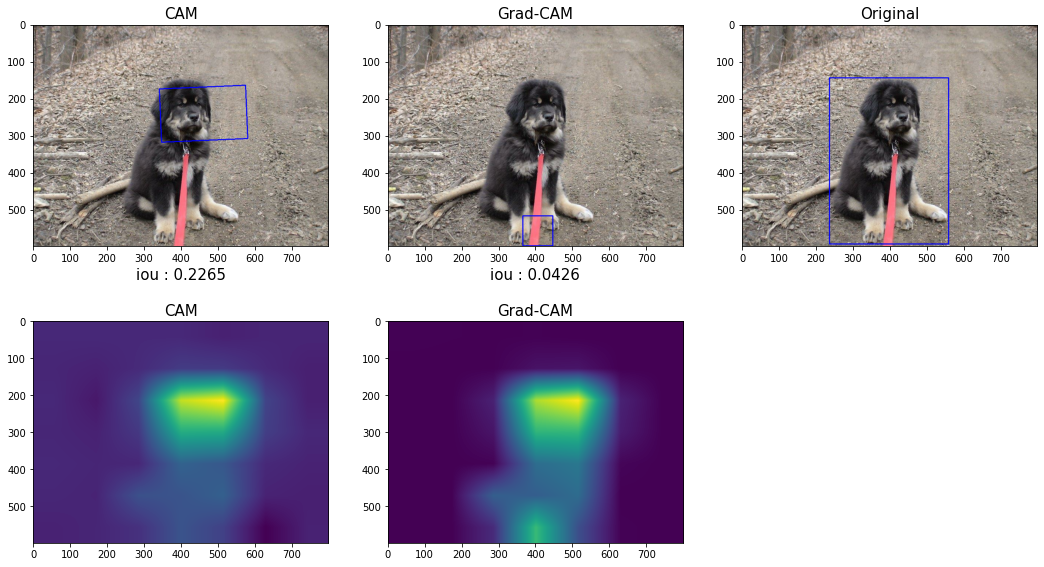

In [73]:
# 샘플 구하기
sample_2 = take_one_sample(ds_train)

# CAM, Grad-CAM
cam_2 = generate_cam(sample_2)
grad_cam_2 = generate_grad_cam(sample_2)

cam_2_copy = copy.deepcopy(cam_2)
grad_cam_2_copy = copy.deepcopy(grad_cam_2)

# bbox(8개 좌표) 구하기 및 시각화 자료 모으기
cam_bbox_on_original, cam_2_rect = get_and_draw_bbox(sample_2, cam_2_copy)
grad_cam_bbox_on_original, grad_cam_2_rect = get_and_draw_bbox(sample_2, grad_cam_2_copy)

# 시각화 자료 모으기
cam_bbox_on_cam = cv2.drawContours(cam_2_copy, [cam_2_rect], 0, (0, 0, 255), 2)
grad_cam_bbox_on_cam = cv2.drawContours(grad_cam_2_copy, [grad_cam_2_rect], 0, (0, 0, 255), 2)

original_rect = bbox_to_rect(sample_2)
bbox_on_original = draw_bbox(sample_2, original_rect)

# bbox(4개 좌표) 구하기
cam_2_bbox = rect_to_bbox(cam_2_rect, cam_2)
grad_cam_2_bbox = rect_to_bbox(grad_cam_2_rect, grad_cam_2)
gt_bx = sample_2['objects']['bbox']

# IoU 계산
cam_2_iou = get_iou(cam_2_bbox, gt_bx[0])
grad_cam_2_iou = get_iou(grad_cam_2_bbox, gt_bx[0])

# 시각화
plt.figure(figsize=(18, 10))

plt.subplot(2, 3, 1)
plt.imshow(cam_bbox_on_original)
plt.title('CAM', fontsize=15)
plt.xlabel(f'iou : {cam_2_iou :.4f}', fontsize=15)
# plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(grad_cam_bbox_on_original)
plt.title('Grad-CAM', fontsize=15)
plt.xlabel(f'iou : {grad_cam_2_iou :.4f}', fontsize=15)
# plt.axis('off')

plt.subplot(2, 3, 4)
# plt.imshow(cam_bbox_on_cam)
plt.imshow(cam_2)
plt.title('CAM', fontsize=15)
# plt.axis('off')

plt.subplot(2, 3, 5)
# plt.imshow(grad_cam_bbox_on_cam)
plt.imshow(grad_cam_2)
plt.title('Grad-CAM', fontsize=15)
# plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(bbox_on_original)
plt.title('Original', fontsize=15)
# plt.axis('off')

plt.show()

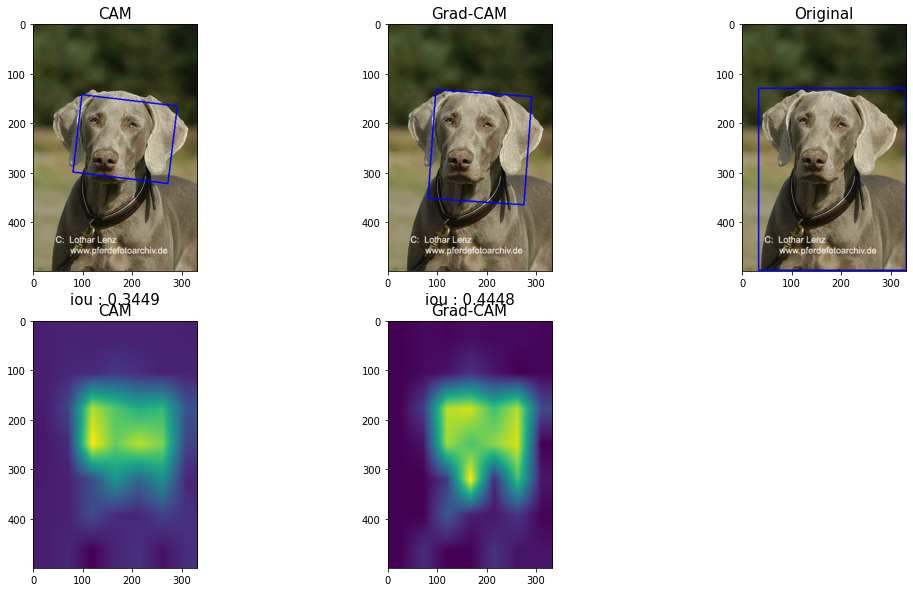

In [74]:
# 샘플 구하기
sample_2 = take_one_sample(ds_train)

# CAM, Grad-CAM
cam_2 = generate_cam(sample_2)
grad_cam_2 = generate_grad_cam(sample_2)

cam_2_copy = copy.deepcopy(cam_2)
grad_cam_2_copy = copy.deepcopy(grad_cam_2)

# bbox(8개 좌표) 구하기 및 시각화 자료 모으기
cam_bbox_on_original, cam_2_rect = get_and_draw_bbox(sample_2, cam_2_copy)
grad_cam_bbox_on_original, grad_cam_2_rect = get_and_draw_bbox(sample_2, grad_cam_2_copy)

# 시각화 자료 모으기
cam_bbox_on_cam = cv2.drawContours(cam_2_copy, [cam_2_rect], 0, (0, 0, 255), 2)
grad_cam_bbox_on_cam = cv2.drawContours(grad_cam_2_copy, [grad_cam_2_rect], 0, (0, 0, 255), 2)

original_rect = bbox_to_rect(sample_2)
bbox_on_original = draw_bbox(sample_2, original_rect)

# bbox(4개 좌표) 구하기
cam_2_bbox = rect_to_bbox(cam_2_rect, cam_2)
grad_cam_2_bbox = rect_to_bbox(grad_cam_2_rect, grad_cam_2)
gt_bx = sample_2['objects']['bbox']

# IoU 계산
cam_2_iou = get_iou(cam_2_bbox, gt_bx[0])
grad_cam_2_iou = get_iou(grad_cam_2_bbox, gt_bx[0])

# 시각화
plt.figure(figsize=(18, 10))

plt.subplot(2, 3, 1)
plt.imshow(cam_bbox_on_original)
plt.title('CAM', fontsize=15)
plt.xlabel(f'iou : {cam_2_iou :.4f}', fontsize=15)
# plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(grad_cam_bbox_on_original)
plt.title('Grad-CAM', fontsize=15)
plt.xlabel(f'iou : {grad_cam_2_iou :.4f}', fontsize=15)
# plt.axis('off')

plt.subplot(2, 3, 4)
# plt.imshow(cam_bbox_on_cam)
plt.imshow(cam_2)
plt.title('CAM', fontsize=15)
# plt.axis('off')

plt.subplot(2, 3, 5)
# plt.imshow(grad_cam_bbox_on_cam)
plt.imshow(grad_cam_2)
plt.title('Grad-CAM', fontsize=15)
# plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(bbox_on_original)
plt.title('Original', fontsize=15)
# plt.axis('off')

plt.show()

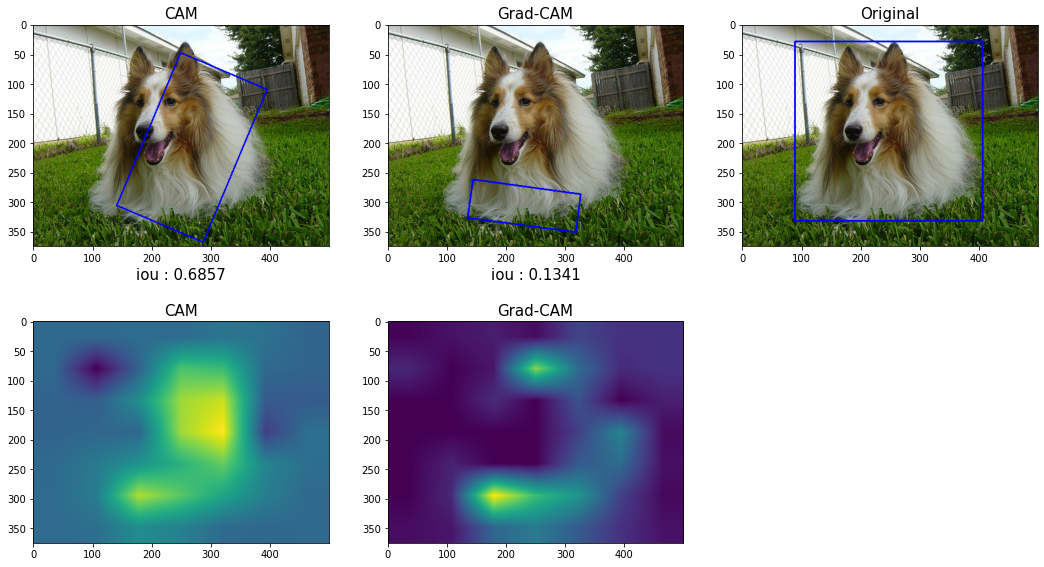

In [75]:
# 샘플 구하기
sample_2 = take_one_sample(ds_train)

# CAM, Grad-CAM
cam_2 = generate_cam(sample_2)
grad_cam_2 = generate_grad_cam(sample_2)

cam_2_copy = copy.deepcopy(cam_2)
grad_cam_2_copy = copy.deepcopy(grad_cam_2)

# bbox(8개 좌표) 구하기 및 시각화 자료 모으기
cam_bbox_on_original, cam_2_rect = get_and_draw_bbox(sample_2, cam_2_copy)
grad_cam_bbox_on_original, grad_cam_2_rect = get_and_draw_bbox(sample_2, grad_cam_2_copy)

# 시각화 자료 모으기
cam_bbox_on_cam = cv2.drawContours(cam_2_copy, [cam_2_rect], 0, (0, 0, 255), 2)
grad_cam_bbox_on_cam = cv2.drawContours(grad_cam_2_copy, [grad_cam_2_rect], 0, (0, 0, 255), 2)

original_rect = bbox_to_rect(sample_2)
bbox_on_original = draw_bbox(sample_2, original_rect)

# bbox(4개 좌표) 구하기
cam_2_bbox = rect_to_bbox(cam_2_rect, cam_2)
grad_cam_2_bbox = rect_to_bbox(grad_cam_2_rect, grad_cam_2)
gt_bx = sample_2['objects']['bbox']

# IoU 계산
cam_2_iou = get_iou(cam_2_bbox, gt_bx[0])
grad_cam_2_iou = get_iou(grad_cam_2_bbox, gt_bx[0])

# 시각화
plt.figure(figsize=(18, 10))

plt.subplot(2, 3, 1)
plt.imshow(cam_bbox_on_original)
plt.title('CAM', fontsize=15)
plt.xlabel(f'iou : {cam_2_iou :.4f}', fontsize=15)
# plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(grad_cam_bbox_on_original)
plt.title('Grad-CAM', fontsize=15)
plt.xlabel(f'iou : {grad_cam_2_iou :.4f}', fontsize=15)
# plt.axis('off')

plt.subplot(2, 3, 4)
# plt.imshow(cam_bbox_on_cam)
plt.imshow(cam_2)
plt.title('CAM', fontsize=15)
# plt.axis('off')

plt.subplot(2, 3, 5)
# plt.imshow(grad_cam_bbox_on_cam)
plt.imshow(grad_cam_2)
plt.title('Grad-CAM', fontsize=15)
# plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(bbox_on_original)
plt.title('Original', fontsize=15)
# plt.axis('off')

plt.show()

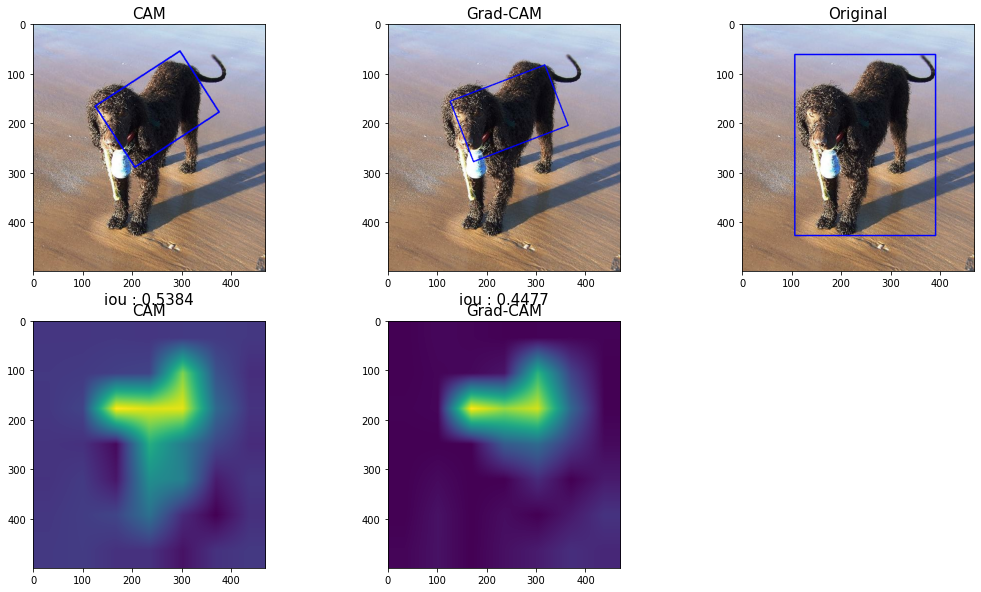

In [76]:
# 샘플 구하기
sample_2 = take_one_sample(ds_train)

# CAM, Grad-CAM
cam_2 = generate_cam(sample_2)
grad_cam_2 = generate_grad_cam(sample_2)

cam_2_copy = copy.deepcopy(cam_2)
grad_cam_2_copy = copy.deepcopy(grad_cam_2)

# bbox(8개 좌표) 구하기 및 시각화 자료 모으기
cam_bbox_on_original, cam_2_rect = get_and_draw_bbox(sample_2, cam_2_copy)
grad_cam_bbox_on_original, grad_cam_2_rect = get_and_draw_bbox(sample_2, grad_cam_2_copy)

# 시각화 자료 모으기
cam_bbox_on_cam = cv2.drawContours(cam_2_copy, [cam_2_rect], 0, (0, 0, 255), 2)
grad_cam_bbox_on_cam = cv2.drawContours(grad_cam_2_copy, [grad_cam_2_rect], 0, (0, 0, 255), 2)

original_rect = bbox_to_rect(sample_2)
bbox_on_original = draw_bbox(sample_2, original_rect)

# bbox(4개 좌표) 구하기
cam_2_bbox = rect_to_bbox(cam_2_rect, cam_2)
grad_cam_2_bbox = rect_to_bbox(grad_cam_2_rect, grad_cam_2)
gt_bx = sample_2['objects']['bbox']

# IoU 계산
cam_2_iou = get_iou(cam_2_bbox, gt_bx[0])
grad_cam_2_iou = get_iou(grad_cam_2_bbox, gt_bx[0])

# 시각화
plt.figure(figsize=(18, 10))

plt.subplot(2, 3, 1)
plt.imshow(cam_bbox_on_original)
plt.title('CAM', fontsize=15)
plt.xlabel(f'iou : {cam_2_iou :.4f}', fontsize=15)
# plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(grad_cam_bbox_on_original)
plt.title('Grad-CAM', fontsize=15)
plt.xlabel(f'iou : {grad_cam_2_iou :.4f}', fontsize=15)
# plt.axis('off')

plt.subplot(2, 3, 4)
# plt.imshow(cam_bbox_on_cam)
plt.imshow(cam_2)
plt.title('CAM', fontsize=15)
# plt.axis('off')

plt.subplot(2, 3, 5)
# plt.imshow(grad_cam_bbox_on_cam)
plt.imshow(grad_cam_2)
plt.title('Grad-CAM', fontsize=15)
# plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(bbox_on_original)
plt.title('Original', fontsize=15)
# plt.axis('off')

plt.show()

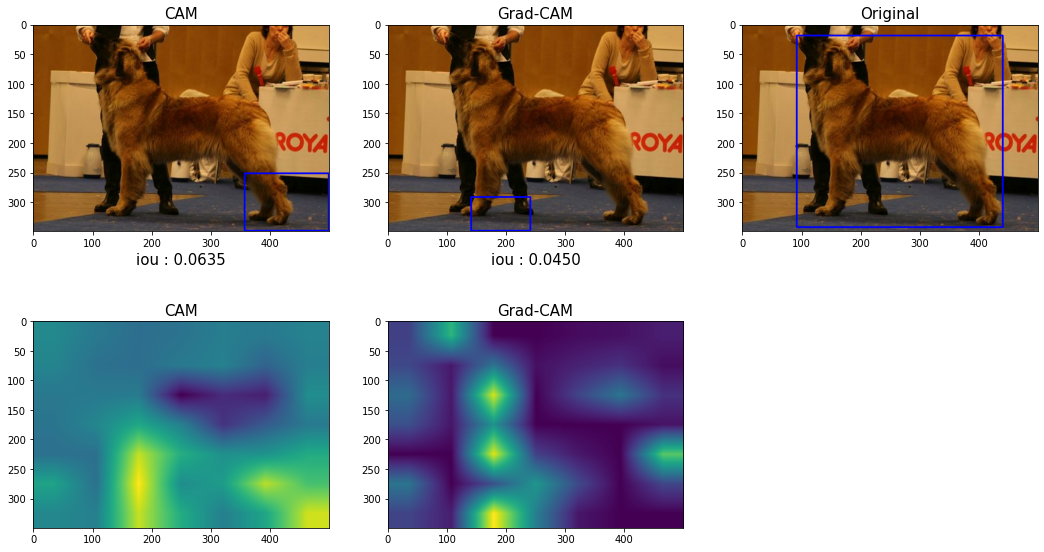

In [77]:
# 샘플 구하기
sample_2 = take_one_sample(ds_train)

# CAM, Grad-CAM
cam_2 = generate_cam(sample_2)
grad_cam_2 = generate_grad_cam(sample_2)

cam_2_copy = copy.deepcopy(cam_2)
grad_cam_2_copy = copy.deepcopy(grad_cam_2)

# bbox(8개 좌표) 구하기 및 시각화 자료 모으기
cam_bbox_on_original, cam_2_rect = get_and_draw_bbox(sample_2, cam_2_copy)
grad_cam_bbox_on_original, grad_cam_2_rect = get_and_draw_bbox(sample_2, grad_cam_2_copy)

# 시각화 자료 모으기
cam_bbox_on_cam = cv2.drawContours(cam_2_copy, [cam_2_rect], 0, (0, 0, 255), 2)
grad_cam_bbox_on_cam = cv2.drawContours(grad_cam_2_copy, [grad_cam_2_rect], 0, (0, 0, 255), 2)

original_rect = bbox_to_rect(sample_2)
bbox_on_original = draw_bbox(sample_2, original_rect)

# bbox(4개 좌표) 구하기
cam_2_bbox = rect_to_bbox(cam_2_rect, cam_2)
grad_cam_2_bbox = rect_to_bbox(grad_cam_2_rect, grad_cam_2)
gt_bx = sample_2['objects']['bbox']

# IoU 계산
cam_2_iou = get_iou(cam_2_bbox, gt_bx[0])
grad_cam_2_iou = get_iou(grad_cam_2_bbox, gt_bx[0])

# 시각화
plt.figure(figsize=(18, 10))

plt.subplot(2, 3, 1)
plt.imshow(cam_bbox_on_original)
plt.title('CAM', fontsize=15)
plt.xlabel(f'iou : {cam_2_iou :.4f}', fontsize=15)
# plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(grad_cam_bbox_on_original)
plt.title('Grad-CAM', fontsize=15)
plt.xlabel(f'iou : {grad_cam_2_iou :.4f}', fontsize=15)
# plt.axis('off')

plt.subplot(2, 3, 4)
# plt.imshow(cam_bbox_on_cam)
plt.imshow(cam_2)
plt.title('CAM', fontsize=15)
# plt.axis('off')

plt.subplot(2, 3, 5)
# plt.imshow(grad_cam_bbox_on_cam)
plt.imshow(grad_cam_2)
plt.title('Grad-CAM', fontsize=15)
# plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(bbox_on_original)
plt.title('Original', fontsize=15)
# plt.axis('off')

plt.show()

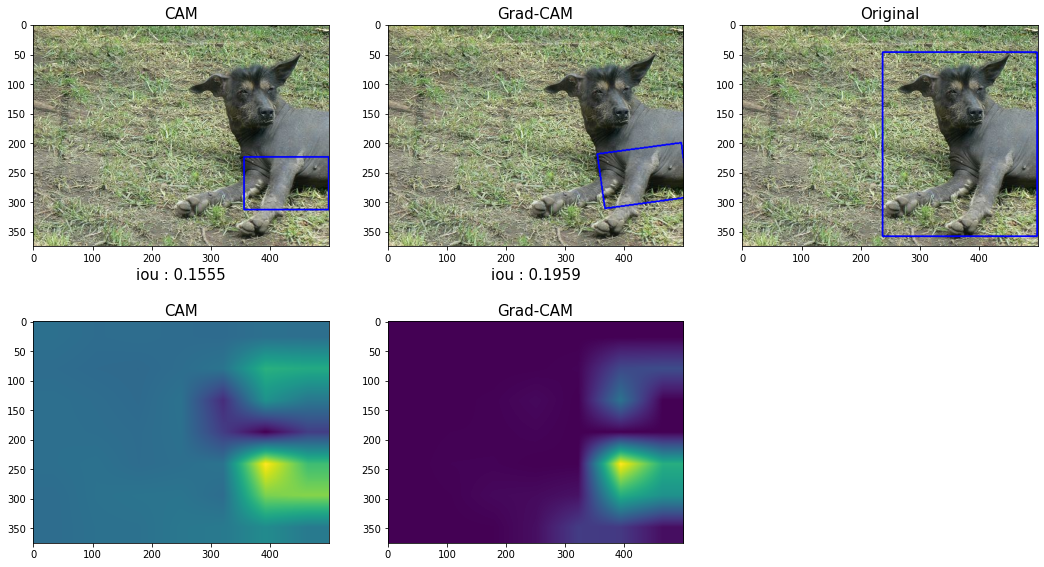

In [78]:
# 샘플 구하기
sample_2 = take_one_sample(ds_train)

# CAM, Grad-CAM
cam_2 = generate_cam(sample_2)
grad_cam_2 = generate_grad_cam(sample_2)

cam_2_copy = copy.deepcopy(cam_2)
grad_cam_2_copy = copy.deepcopy(grad_cam_2)

# bbox(8개 좌표) 구하기 및 시각화 자료 모으기
cam_bbox_on_original, cam_2_rect = get_and_draw_bbox(sample_2, cam_2_copy)
grad_cam_bbox_on_original, grad_cam_2_rect = get_and_draw_bbox(sample_2, grad_cam_2_copy)

# 시각화 자료 모으기
cam_bbox_on_cam = cv2.drawContours(cam_2_copy, [cam_2_rect], 0, (0, 0, 255), 2)
grad_cam_bbox_on_cam = cv2.drawContours(grad_cam_2_copy, [grad_cam_2_rect], 0, (0, 0, 255), 2)

original_rect = bbox_to_rect(sample_2)
bbox_on_original = draw_bbox(sample_2, original_rect)

# bbox(4개 좌표) 구하기
cam_2_bbox = rect_to_bbox(cam_2_rect, cam_2)
grad_cam_2_bbox = rect_to_bbox(grad_cam_2_rect, grad_cam_2)
gt_bx = sample_2['objects']['bbox']

# IoU 계산
cam_2_iou = get_iou(cam_2_bbox, gt_bx[0])
grad_cam_2_iou = get_iou(grad_cam_2_bbox, gt_bx[0])

# 시각화
plt.figure(figsize=(18, 10))

plt.subplot(2, 3, 1)
plt.imshow(cam_bbox_on_original)
plt.title('CAM', fontsize=15)
plt.xlabel(f'iou : {cam_2_iou :.4f}', fontsize=15)
# plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(grad_cam_bbox_on_original)
plt.title('Grad-CAM', fontsize=15)
plt.xlabel(f'iou : {grad_cam_2_iou :.4f}', fontsize=15)
# plt.axis('off')

plt.subplot(2, 3, 4)
# plt.imshow(cam_bbox_on_cam)
plt.imshow(cam_2)
plt.title('CAM', fontsize=15)
# plt.axis('off')

plt.subplot(2, 3, 5)
# plt.imshow(grad_cam_bbox_on_cam)
plt.imshow(grad_cam_2)
plt.title('Grad-CAM', fontsize=15)
# plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(bbox_on_original)
plt.title('Original', fontsize=15)
# plt.axis('off')

plt.show()

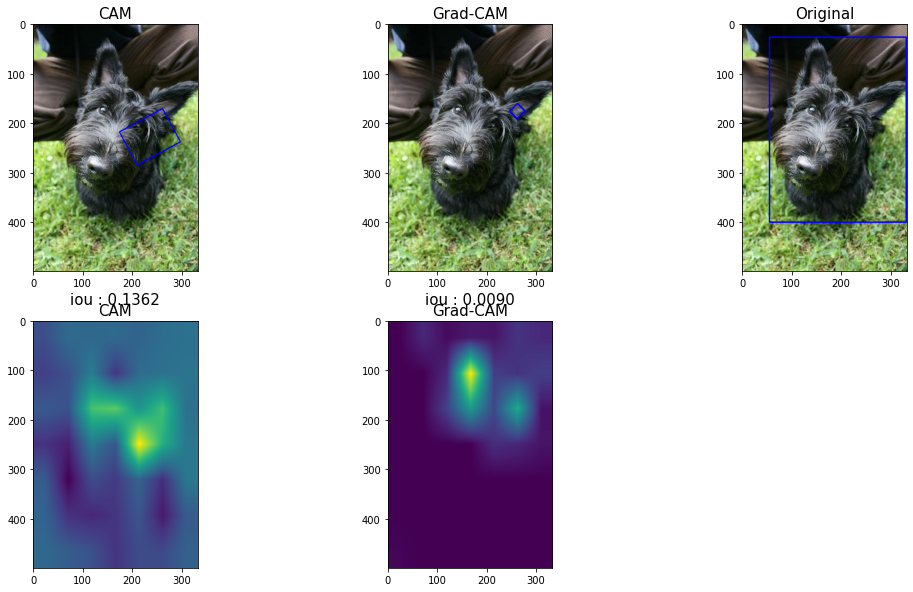

In [80]:
# 샘플 구하기
sample_2 = take_one_sample(ds_test)

# CAM, Grad-CAM
cam_2 = generate_cam(sample_2)
grad_cam_2 = generate_grad_cam(sample_2)

cam_2_copy = copy.deepcopy(cam_2)
grad_cam_2_copy = copy.deepcopy(grad_cam_2)

# bbox(8개 좌표) 구하기 및 시각화 자료 모으기
cam_bbox_on_original, cam_2_rect = get_and_draw_bbox(sample_2, cam_2_copy)
grad_cam_bbox_on_original, grad_cam_2_rect = get_and_draw_bbox(sample_2, grad_cam_2_copy)

# 시각화 자료 모으기
cam_bbox_on_cam = cv2.drawContours(cam_2_copy, [cam_2_rect], 0, (0, 0, 255), 2)
grad_cam_bbox_on_cam = cv2.drawContours(grad_cam_2_copy, [grad_cam_2_rect], 0, (0, 0, 255), 2)

original_rect = bbox_to_rect(sample_2)
bbox_on_original = draw_bbox(sample_2, original_rect)

# bbox(4개 좌표) 구하기
cam_2_bbox = rect_to_bbox(cam_2_rect, cam_2)
grad_cam_2_bbox = rect_to_bbox(grad_cam_2_rect, grad_cam_2)
gt_bx = sample_2['objects']['bbox']

# IoU 계산
cam_2_iou = get_iou(cam_2_bbox, gt_bx[0])
grad_cam_2_iou = get_iou(grad_cam_2_bbox, gt_bx[0])

# 시각화
plt.figure(figsize=(18, 10))

plt.subplot(2, 3, 1)
plt.imshow(cam_bbox_on_original)
plt.title('CAM', fontsize=15)
plt.xlabel(f'iou : {cam_2_iou :.4f}', fontsize=15)
# plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(grad_cam_bbox_on_original)
plt.title('Grad-CAM', fontsize=15)
plt.xlabel(f'iou : {grad_cam_2_iou :.4f}', fontsize=15)
# plt.axis('off')

plt.subplot(2, 3, 4)
# plt.imshow(cam_bbox_on_cam)
plt.imshow(cam_2)
plt.title('CAM', fontsize=15)
# plt.axis('off')

plt.subplot(2, 3, 5)
# plt.imshow(grad_cam_bbox_on_cam)
plt.imshow(grad_cam_2)
plt.title('Grad-CAM', fontsize=15)
# plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(bbox_on_original)
plt.title('Original', fontsize=15)
# plt.axis('off')

plt.show()

#### 결론
- CAM, Grad-CAM을 통해 bounding box를 구하는 것은 다소 무리가 있지 않을까 싶다. 생각해보면 그 둘의 경우 이미지를 판별하는 데 특징적인 부분이 강조되는 것인데 bounding box는 사물의 특징적인 부분만 아니라 전체를 덮어야 하니 큰 기대를 하는 건 어렵지 않을까 싶다.
- 또한, 모델의 훈련량도 영향을 많이 미치는 건지 아직 많은 수준으로 GT에 차이가 난다. 이 경우 bounding box에 포함할 pixel threshold를 좀 낮추면 더 넓은 영역이 포함되지 않을까 싶다.